# Team Segmentation Evaluation

### Importing Common Libraries and Setting Up Globals

In [19]:
import sys

# Set this to the absolute path of your project root
project_root = "/Users/fernandomousinho/Documents/Learning_to_Code/LaxAI"
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from typing import Optional, List, Dict, Tuple
import torch
import supervision as sv
from tqdm import tqdm
from collections import deque
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image
import umap

from modules.detection import DetectionModel
from modules.player import Player
from modules.team_identification import TeamIdentification
from tools.store_driver import Store
from modules.custom_tracker import AffineAwareByteTrack
from modules.Siglip_reid import SiglipReID

Defining video input parameters

In [3]:
input_video = "/Users/fernandomousinho/Library/CloudStorage/GoogleDrive-fmousinho76@gmail.com/My Drive/Colab_Notebooks/FCA_Upstate_NY_003.mp4"
store = Store()
device = torch.device("cpu")
debug_max_frames = 200

Gathering required crops. We are saving crops_for_team_id_backup, which can be copied to crops_for_team_id in each experiment.

In [4]:
video_info = sv.VideoInfo.from_video_path(video_path=input_video)
generator_params = {
    "source_path": input_video,
    "end": debug_max_frames if debug_max_frames else video_info.total_frames,
}
frames_generator = sv.get_video_frames_generator(**generator_params)
model = DetectionModel(store=store, device=device)

tracker = AffineAwareByteTrack() 
team_identifier = TeamIdentification()
emb_provider = SiglipReID()

ellipse_annotator = sv.EllipseAnnotator()
label_annotator = sv.LabelAnnotator()
multi_frame_detections = deque()
multi_ineligible_track_ids_team_0: deque[list[int]] = deque()
multi_ineligible_track_ids_team_1: deque[list[int]] = deque()
trackerid_to_reid_data: Dict[int, Tuple[np.ndarray, int]] = {}

frame_target = debug_max_frames if debug_max_frames else video_info.total_frames

# Identifying teams
_N_FRAMES_FOR_TEAM_ID = 100
_PLAYER_CLASS_ID = 3

stride = frame_target // _N_FRAMES_FOR_TEAM_ID if frame_target >= _N_FRAMES_FOR_TEAM_ID else 1
crops_for_team_id: List[np.ndarray] = []
# Create a fresh generator for this step to avoid exhaustion
frame_generator_for_team_id = sv.get_video_frames_generator(stride=stride, **generator_params)

# Calculate how many frames will actually be processed for progress bar
n_frames_for_team_id = frame_target // stride if stride > 0 else frame_target
for frame in tqdm(frame_generator_for_team_id, desc="Gathering crops for team identification", total=n_frames_for_team_id):
    all_detections = model.generate_detections(frame)
    # all_detections = all_detections.with_nms(threshold=0.9, class_agnostic=True)
    player_detections = all_detections[all_detections.class_id == _PLAYER_CLASS_ID]
    for bbox in player_detections.xyxy:
        crop = sv.crop_image(frame, xyxy=bbox)
        if crop is not None:
            crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)  # Ensure crop is in RGB format
            crops_for_team_id.append(crop)

crops_for_team_id_backup = crops_for_team_id.copy()

Loading pretrain weights


Gathering crops for team identification: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


Saving a backup for the flattened version of each crop, in normalized RGB.

In [5]:
crops = crops_for_team_id_backup.copy()
roi_crops = [crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :] for crop in crops]
shapes = []
flat_crop_array = []
for crop_copy in roi_crops:
    crop = crop_copy.copy()
    shapes.append(crop.shape)
    flat_crop = crop.reshape(-1, 3)
    flat_crop = flat_crop.astype(np.float32)
    flat_crop_norm = flat_crop / 255.0
    flat_crop_array.append(flat_crop_norm)
flat_crop_norm = np.concatenate(flat_crop_array, axis=0)
flat_crop_norm_backup = flat_crop_norm.copy()


Checking if it is really RGB!

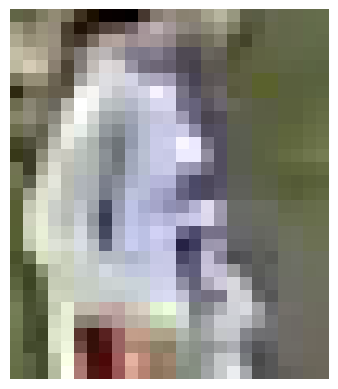

In [6]:
plt.imshow(roi_crops[0])
plt.axis('off')
plt.show()

##### Update SIGLip Module ####

Only required if it needs reload.

In [ ]:
import importlib
import modules.Siglip_reid  # Import the module first
importlib.reload(modules.Siglip_reid)  # Reload the module
from modules.Siglip_reid import SiglipReID  # Re-import the class

### Experiment 1: Testing different color formats to kmeans a grass mask.

#### RGB ####
Not good enough. The dark parts of the uniform are being masked-out, preventing an accurate team separation

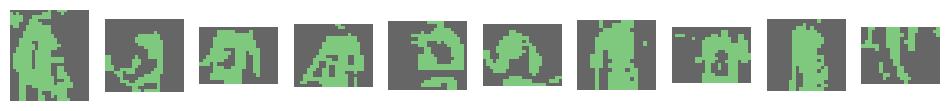

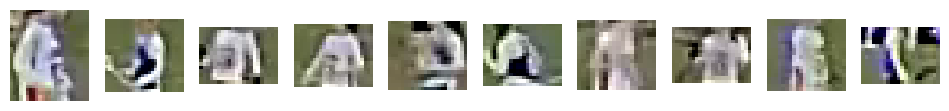

In [9]:
flat_crop_norm = flat_crop_norm_backup.copy()
kmeans_background = KMeans(n_clusters=2, random_state = 42)
player_or_grass_mask = kmeans_background.fit_predict(flat_crop_norm)
masked_crops = []
start = 0
stop = 0
for shape in shapes:
    stop = start + shape[0] * shape[1] 
    flat_crop = player_or_grass_mask[start:stop]
    masked_crop = np.reshape(flat_crop, shape[:2])
    masked_crops.append(masked_crop.copy())
    start = stop

sv.plot_images_grid(masked_crops[:10], grid_size=(1, 10), cmap='Accent')

roi_for_plot_bgr = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop in roi_crops]
sv.plot_images_grid(roi_for_plot_bgr[:10], grid_size=(1, 10))

#### HSV ####

Same results as before.

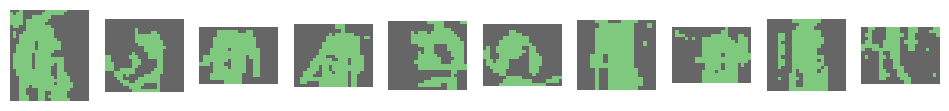

In [11]:
crops = crops_for_team_id_backup.copy()
roi_crops = [crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :] for crop in crops]
roi_crops_hue = [cv2.cvtColor(crop, cv2.COLOR_BGR2HSV) for crop in roi_crops]
shapes = []
flat_crop_array = []
for crop in roi_crops_hue:
    shapes.append(crop.shape)
    flat_crop = crop.reshape(-1, 3)
    flat_crop_array.append(flat_crop)
flat_crop_np = np.concatenate(flat_crop_array, axis=0)


kmeans_background = KMeans(n_clusters=2, random_state = 42)
player_or_grass_mask = kmeans_background.fit_predict(flat_crop_np)
masked_crops = []
start = 0
stop = 0
for shape in shapes:
    stop = start + shape[0] * shape[1] 
    flat_crop = player_or_grass_mask[start:stop]
    masked_crop = np.reshape(flat_crop, shape[:2])
    masked_crops.append(masked_crop.copy())
    start = stop

sv.plot_images_grid(masked_crops[:10], grid_size=(1, 10), cmap='Accent')

#### LAB ####

Same as before.

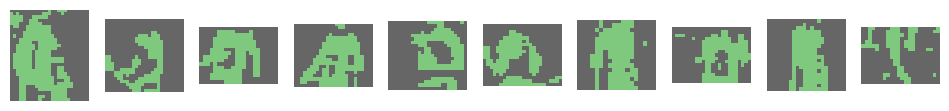

In [13]:
crops = crops_for_team_id_backup.copy()
roi_crops = [crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :] for crop in crops]
roi_crops_lab = [cv2.cvtColor(crop, cv2.COLOR_BGR2LAB) for crop in roi_crops]
shapes = []
flat_crop_array = []
for crop in roi_crops_lab:
    shapes.append(crop.shape)
    flat_crop = crop.reshape(-1, 3)
    flat_crop_array.append(flat_crop)
flat_crop_np = np.concatenate(flat_crop_array, axis=0)


kmeans_background = KMeans(n_clusters=2, random_state = 42)
player_or_grass_mask = kmeans_background.fit_predict(flat_crop_np)
masked_crops = []
start = 0
stop = 0
for shape in shapes:
    stop = start + shape[0] * shape[1] 
    flat_crop = player_or_grass_mask[start:stop]
    masked_crop = np.reshape(flat_crop, shape[:2])
    masked_crops.append(masked_crop.copy())
    start = stop

sv.plot_images_grid(masked_crops[:10], grid_size=(1, 10), cmap='Accent')

Verifying that the resulting masked colors really don't work.

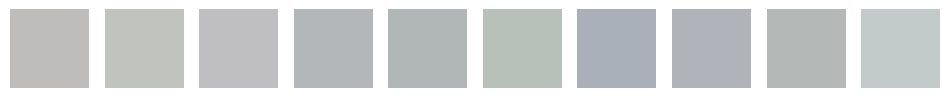

In [14]:
pic = masked_crops[0].copy()
edge_colors = [pic[0, 0], pic[0, -1], pic[-1, 0], pic[-1, -1]]
background_cluster = max(set(edge_colors), key=edge_colors.count)
player_img_cluster = 1 - background_cluster
crops_mean_color = []
for crop, masked_crop in zip(roi_crops, masked_crops):
    mean_color = np.mean(crop[masked_crop == player_img_cluster], axis=0).astype(np.uint8)
    mean_color = cv2.cvtColor(mean_color.reshape(1, 1, 3), cv2.COLOR_BGR2RGB)
    crops_mean_color.append(mean_color.reshape(3))

color_patches = [np.full((50, 50, 3), color, dtype=np.uint8) for color in crops_mean_color[:10]]
color_patches = [cv2.cvtColor(patch, cv2.COLOR_RGB2BGR) for patch in color_patches]
sv.plot_images_grid(color_patches, grid_size=(1, 10))

### Experiment 2: Morphological Operations ###

Check https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html

#### Generate Morphological Masks ####

Original crops


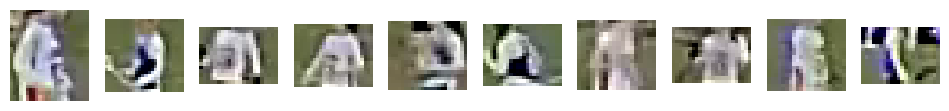

Masks


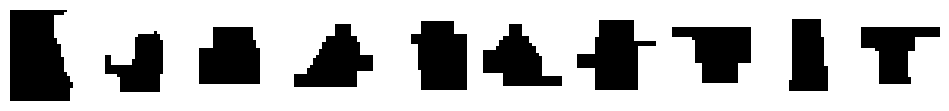

Masked crops


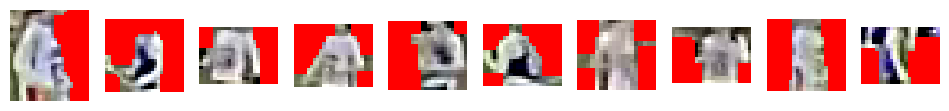

In [7]:
flat_crop_norm = flat_crop_norm_backup.copy()
kmeans_background = KMeans(n_clusters=2, random_state = 42)
player_or_grass_mask = kmeans_background.fit_predict(flat_crop_norm)
masked_crops = []
masks_rgb = []
start = 0
stop = 0
kernel_open_size = 7
kernel_close_size = 1
kernel_open = np.ones((kernel_open_size, kernel_open_size), np.uint8)
kernel_close = np.ones((kernel_close_size, kernel_close_size), np.uint8)
for i, shape in enumerate(shapes):
    stop = start + shape[0] * shape[1] 
    flat_mask = player_or_grass_mask[start:stop]
    mask = np.reshape(flat_mask, shape[:2])
    mask_rgb = cv2.cvtColor(mask.astype(np.uint8) * 255, cv2.COLOR_GRAY2RGB)

    mask_rgb = cv2.morphologyEx(mask_rgb, cv2.MORPH_OPEN, kernel_open)
    #mask_rgb = cv2.morphologyEx(mask_rgb, cv2.MORPH_CLOSE, kernel_close)
    mask = cv2.bitwise_not(mask_rgb[:, :, 0])

    masked_crop = roi_crops[i].copy()
    masked_crop = cv2.bitwise_and(masked_crop, masked_crop, mask=mask)
    masked_crop[mask == 0] = [255, 0, 0]

    masks_rgb.append(mask_rgb.copy())
    masked_crops.append(masked_crop)
    start = stop


print("Original crops")
roi_for_plot_bgr = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop in roi_crops]
sv.plot_images_grid(roi_for_plot_bgr[:10], grid_size=(1, 10))

print("Masks")
sv.plot_images_grid(masks_rgb[:10], grid_size=(1, 10), cmap='Accent')

print("Masked crops")
masked_crops_bgr = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop in masked_crops]
sv.plot_images_grid(masked_crops_bgr[:10], grid_size=(1, 10))



#### Use SIPGLip embeddings ####

First we create the embeddings

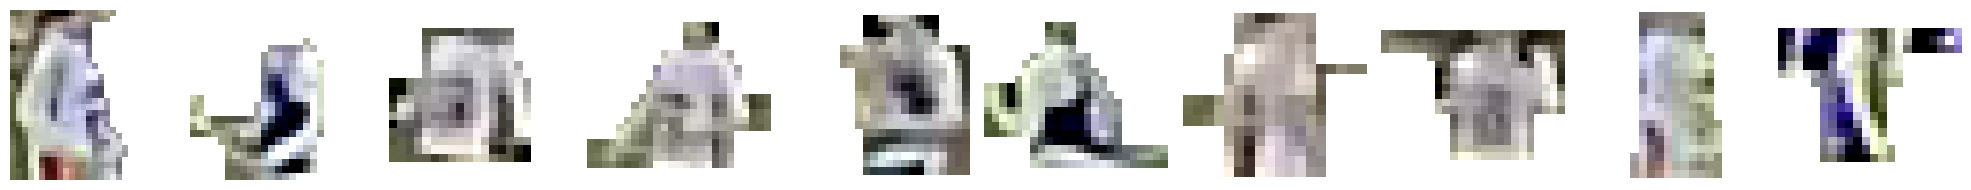

In [13]:
emb_provider = SiglipReID()
crops_pil = []
for i, masked_crop in enumerate(masked_crops):
    # Assume red background is [255, 0, 0] in RGB (or [0, 0, 255] in BGR)
    # If your masked_crop is RGB:
    masked_crop_rgb = masked_crop.copy()
    red_mask = np.all(masked_crop == [255, 0, 0], axis=-1)
    # If your masked_crop is BGR, use [0, 0, 255] instead
    masked_crop_rgb[red_mask] = [255, 255, 255]
    masked_crop_pil = Image.fromarray(masked_crop_rgb, mode="RGB")
    crops_pil.append(masked_crop_pil.copy())


fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, img in enumerate(crops_pil[:10]):
    axes[i].imshow(np.array(img))
    axes[i].axis('off')
plt.tight_layout()
plt.show()



In [14]:
embs = emb_provider.get_emb_from_crops(crops_pil, format="Pillow")

Generating embeddings: 100%|██████████| 53/53 [00:30<00:00,  1.73it/s]


Then we create 3D projections

In [20]:
REDUCER = umap.UMAP(n_components=3)
embs_3d = REDUCER.fit_transform(embs)

Then we create the clusters

Team 0


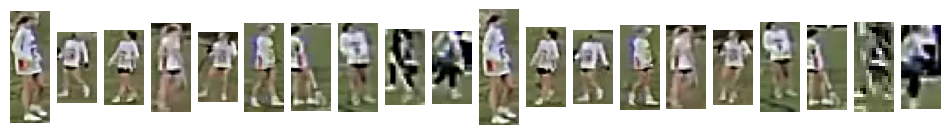

Team 1


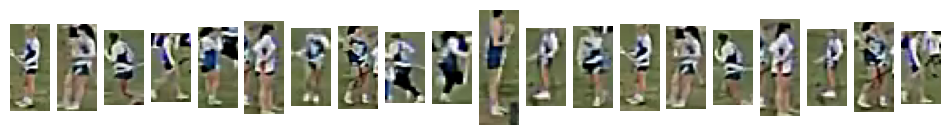

In [21]:
kmeans = KMeans(n_clusters=2, random_state=42)
embs_np = np.array(embs_3d)
team_identifier = kmeans.fit_predict(embs_np)

team_0 = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop, team in zip(crops_for_team_id, team_identifier) if team == 0]
team_1 = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop, team in zip(crops_for_team_id, team_identifier) if team == 1]

print("Team 0")
sv.plot_images_grid(team_0[:20], grid_size=(1, 20))

print("Team 1")
sv.plot_images_grid(team_1[:20], grid_size=(1, 20))

#### Using average color ####

Calculating average colors

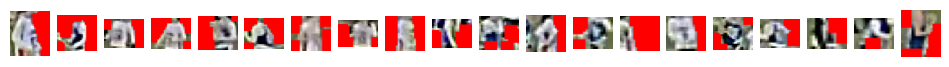

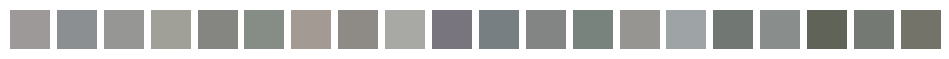

In [11]:
avg_colors = []
for crop in masked_crops:
    flat_crop = crop.reshape(-1, 3)
    red_mask = np.all(flat_crop == [255, 0, 0], axis=-1)
    flat_crop = flat_crop[~red_mask]  # Exclude red pixels
    crop_reshaped = flat_crop.reshape(1, -1, 3)
    crop_lab = cv2.cvtColor(crop_reshaped, cv2.COLOR_RGB2LAB)
    avg_color = np.mean(crop_lab, axis=(0, 1)).astype(np.uint8)
    avg_color = avg_color.reshape(1, 1, 3)  # Reshape for color conversion
    avg_color_bgr = cv2.cvtColor(avg_color, cv2.COLOR_LAB2BGR)
    avg_color_bgr = avg_color_bgr.reshape(3)  # Reshape to 1D array
    avg_colors.append(avg_color_bgr.copy())

color_patches = [np.full((5, 5, 3), color, dtype=np.uint8) for color in avg_colors]
masked_crops_bgr = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop in masked_crops]
sv.plot_images_grid(masked_crops_bgr[:20], grid_size=(1, 20))
sv.plot_images_grid(color_patches[:20], grid_size=(1, 20))

Team 0


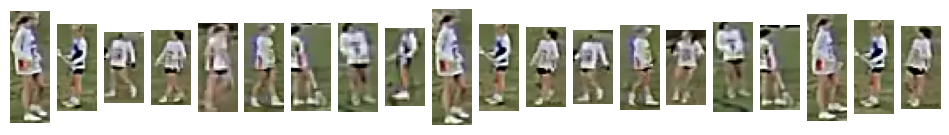

Team 1


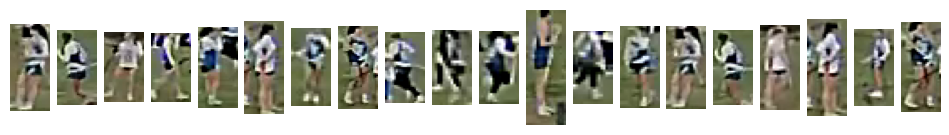

In [12]:
kmeans = KMeans(n_clusters=2, random_state=42)

embs_np = np.array(avg_colors)
 # Reshape to 2D array for KMeans
team_identifier = kmeans.fit_predict(embs_np)

team_0 = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop, team in zip(crops_for_team_id, team_identifier) if team == 0]
team_1 = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop, team in zip(crops_for_team_id, team_identifier) if team == 1]

print("Team 0")
sv.plot_images_grid(team_0[:20], grid_size=(1, 20))

print("Team 1")
sv.plot_images_grid(team_1[:20], grid_size=(1, 20))

### Experiment 3: Calculating the grass color and filtering it out.

#### Extract Grass Color ####

Gathering crops

Gathering crops for grass color: 100%|██████████| 5/5 [00:00<00:00, 17.94it/s]


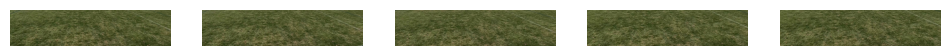

In [30]:
stride = frame_target // 5
crops_for_grass_color: List[np.ndarray] = []

frame_generator_for_grass_color = sv.get_video_frames_generator(stride=stride, **generator_params)

n_frames_for_grass_color = frame_target // stride if stride > 0 else frame_target
for frame in tqdm(frame_generator_for_grass_color, desc="Gathering crops for grass color", total=n_frames_for_grass_color):
    #removing the top 50% of the frame to avoid sky and the bottom 10% to avoid expectators
    crop = frame[int(frame.shape[0]*0.5):int(frame.shape[0]*0.9), :, :]
    crops_for_grass_color.append(crop)

sv.plot_images_grid(crops_for_grass_color, grid_size=(1, 5))


Calculating grass color mean and standard deviation using LAB.

Grass mean color: [ 94 118 150]
Grass std color: [33  1  2]
Grass mean color in RGB: [83 90 50]


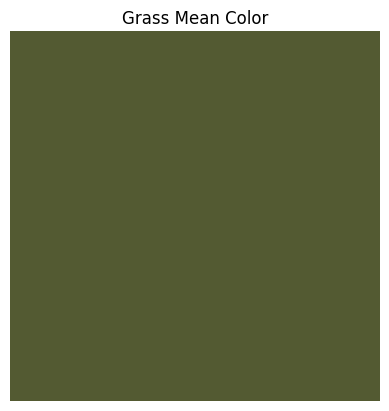

In [31]:
crops_for_grass_color_lab = [cv2.cvtColor(crop, cv2.COLOR_BGR2Lab) for crop in crops_for_grass_color]
crops_for_grass_color_lab = [crop.reshape(-1, 3) for crop in crops_for_grass_color_lab]
grass_flat_lab = np.concatenate(crops_for_grass_color_lab, axis=0)
grass_mean_color_lab = np.mean(grass_flat_lab, axis=0).astype(np.uint8)
grass_std_color_lab = np.std(grass_flat_lab, axis=0).astype(np.uint8)
print(f"Grass mean color: {grass_mean_color_lab}")
print(f"Grass std color: {grass_std_color_lab}")

grass_mean_color_rgb = cv2.cvtColor(grass_mean_color_lab.reshape(1, 1, 3), cv2.COLOR_LAB2RGB).reshape(3)
print(f"Grass mean color in RGB: {grass_mean_color_rgb}")

color_patch = np.full((5, 5, 3), grass_mean_color_rgb, dtype=np.uint8)
plt.imshow(color_patch)
plt.title("Grass Mean Color")
plt.axis('off')
plt.show()


Calculating grass color ranges based on number of standard deviations

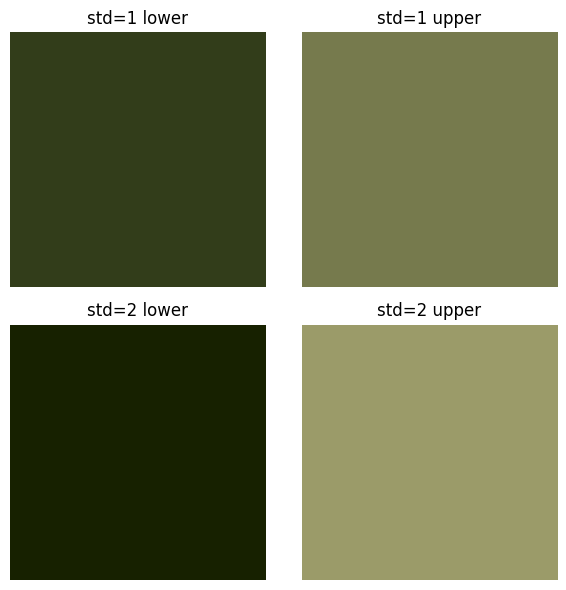

In [32]:

std_deviations = [1, 2]

lower_bounds = {}
upper_bounds = {}

for std in std_deviations:
    lower = grass_mean_color_lab - std * grass_std_color_lab
    upper = grass_mean_color_lab + std * grass_std_color_lab
    lower = np.clip(lower, 0, 255).astype(np.uint8)
    upper = np.clip(upper, 0, 255).astype(np.uint8)
    lower_bounds[std] = lower
    upper_bounds[std] = upper

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for row, std in enumerate(std_deviations):
    # Lower bound patch
    lower_patch = np.full((5, 5, 3), lower_bounds[std], dtype=np.uint8)
    lower_patch = cv2.cvtColor(lower_patch, cv2.COLOR_LAB2RGB)
    axes[row, 0].imshow(lower_patch)
    axes[row, 0].set_title(f"std={std} lower")
    axes[row, 0].axis('off')
    # Upper bound patch
    upper_patch = np.full((5, 5, 3), upper_bounds[std], dtype=np.uint8)
    upper_patch = cv2.cvtColor(upper_patch, cv2.COLOR_LAB2RGB)
    axes[row, 1].imshow(upper_patch)
    axes[row, 1].set_title(f"std={std} upper")
    axes[row, 1].axis('off')

plt.tight_layout()
plt.show()


#### Removing Grass Background ####

While 1 is not aggressive enough, 2 standard deviations is overly aggressive.

Original ROI Crops:


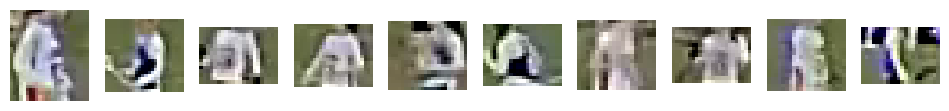

Masked ROI Crops (1 std):


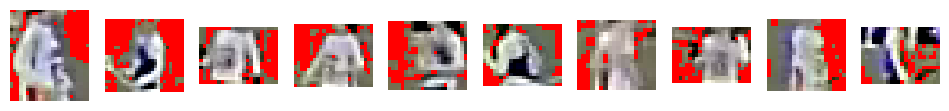

Masked ROI Crops (2 std):


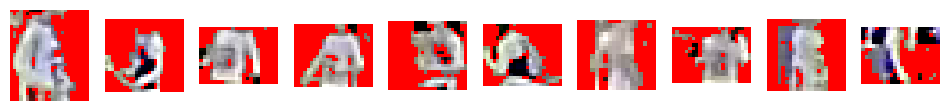

In [39]:
roi_crops = [crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :] for crop in crops_for_team_id_backup]

roi_crops_masked_1std = []
roi_crops_masked_2std = []

lower1 = cv2.cvtColor(lower_bounds[1].reshape(1, 1, 3), cv2.COLOR_LAB2RGB).reshape(3)
upper1 = cv2.cvtColor(upper_bounds[1].reshape(1, 1, 3), cv2.COLOR_LAB2RGB).reshape(3)
lower2 = cv2.cvtColor(lower_bounds[2].reshape(1, 1, 3), cv2.COLOR_LAB2RGB).reshape(3)
upper2 = cv2.cvtColor(upper_bounds[2].reshape(1, 1, 3), cv2.COLOR_LAB2RGB).reshape(3)

lower1 = np.clip(lower1, 0, 255).astype(np.uint8)
upper1 = np.clip(upper1, 0, 255).astype(np.uint8)
lower2 = np.clip(lower2, 0, 255).astype(np.uint8)
upper2 = np.clip(upper2, 0, 255).astype(np.uint8)

for crop in roi_crops:
    # 1 std mask
    mask1 = cv2.inRange(crop, lower1, upper1)
    crop_masked1 = crop.copy()
    crop_masked1[mask1 > 0] = [255, 0, 0]
    roi_crops_masked_1std.append(crop_masked1)
    # 2 std mask
    mask2 = cv2.inRange(crop, lower2, upper2)
    crop_masked2 = crop.copy()
    crop_masked2[mask2 > 0] = [255, 0, 0]
    roi_crops_masked_2std.append(crop_masked2)

# Plot first 10 for each flavor
print("Original ROI Crops:")
sv.plot_images_grid([cv2.cvtColor(c, cv2.COLOR_RGB2BGR) for c in roi_crops[:10]], grid_size=(1, 10))
print("Masked ROI Crops (1 std):")
sv.plot_images_grid([cv2.cvtColor(c, cv2.COLOR_RGB2BGR) for c in roi_crops_masked_1std[:10]], grid_size=(1, 10))
print("Masked ROI Crops (2 std):")
sv.plot_images_grid([cv2.cvtColor(c, cv2.COLOR_RGB2BGR) for c in roi_crops_masked_2std[:10]], grid_size=(1, 10))

Fixing the interval

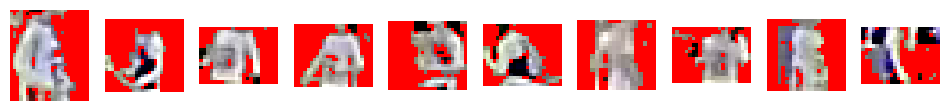

In [40]:
std = 2

lower = grass_mean_color_lab - std * grass_std_color_lab
upper = grass_mean_color_lab + std * grass_std_color_lab
lower = np.clip(lower, 0, 255).astype(np.uint8)
upper = np.clip(upper, 0, 255).astype(np.uint8)

roi_crops = [crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :] for crop in crops_for_team_id_backup]
roi_crops_masked = []

lower = cv2.cvtColor(lower.reshape(1, 1, 3), cv2.COLOR_LAB2RGB).reshape(3)
upper = cv2.cvtColor(upper.reshape(1, 1, 3), cv2.COLOR_LAB2RGB).reshape(3)

lower = np.clip(lower, 0, 255).astype(np.uint8)
upper = np.clip(upper, 0, 255).astype(np.uint8)

for crop in roi_crops:
    mask = cv2.inRange(crop, lower, upper)
    crop_masked = crop.copy()
    crop_masked[mask > 0] = [255, 0, 0]
    roi_crops_masked.append(crop_masked)

sv.plot_images_grid([cv2.cvtColor(c, cv2.COLOR_RGB2BGR) for c in roi_crops_masked[:10]], grid_size=(1, 10))
 


#### Cluster Using Average Colors ####

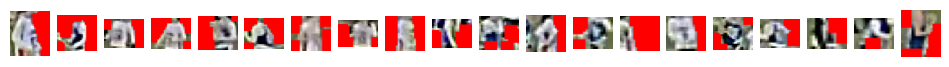

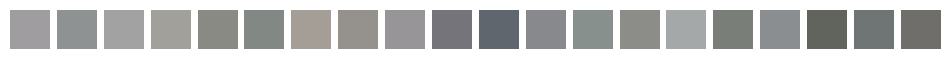

In [211]:
avg_colors = []
for crop in roi_crops_masked:
    flat_crop = crop.reshape(-1, 3)
    red_mask = np.all(flat_crop == [255, 0, 0], axis=-1)
    flat_crop = flat_crop[~red_mask]  # Exclude red pixels
    crop_reshaped = flat_crop.reshape(1, -1, 3)
    crop_lab = cv2.cvtColor(crop_reshaped, cv2.COLOR_RGB2LAB)
    avg_color = np.mean(crop_lab, axis=(0, 1)).astype(np.uint8)
    avg_color = avg_color.reshape(1, 1, 3)  # Reshape for color conversion
    avg_color_bgr = cv2.cvtColor(avg_color, cv2.COLOR_LAB2BGR)
    avg_color_bgr = avg_color_bgr.reshape(3)  # Reshape to 1D array
    avg_colors.append(avg_color_bgr.copy())

color_patches = [np.full((5, 5, 3), color, dtype=np.uint8) for color in avg_colors]
masked_crops_bgr = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop in masked_crops]
sv.plot_images_grid(masked_crops_bgr[:20], grid_size=(1, 20))
sv.plot_images_grid(color_patches[:20], grid_size=(1, 20))

Separate Teams

Team 0


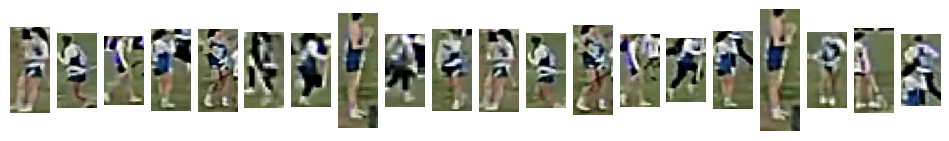

Team 1


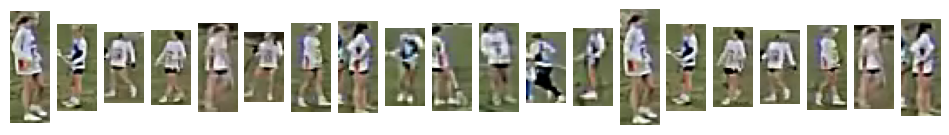

In [212]:
kmeans = KMeans(n_clusters=2, random_state=42)

embs_np = np.array(avg_colors)
 # Reshape to 2D array for KMeans
team_identifier = kmeans.fit_predict(embs_np)

team_0 = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop, team in zip(crops_for_team_id, team_identifier) if team == 0]
team_1 = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop, team in zip(crops_for_team_id, team_identifier) if team == 1]

print("Team 0")
sv.plot_images_grid(team_0[:20], grid_size=(1, 20))

print("Team 1")
sv.plot_images_grid(team_1[:20], grid_size=(1, 20))

#### Cluster Using SigLip ####

Creating embeddings

In [41]:
emb_provider = SiglipReID()
crops_pil = []
for i, masked_crop in enumerate(roi_crops_masked):
    # Assume red background is [255, 0, 0] in RGB (or [0, 0, 255] in BGR)
    # If your masked_crop is RGB:
    masked_crop_rgb = masked_crop.copy()
    red_mask = np.all(masked_crop == [255, 0, 0], axis=-1)
    # If your masked_crop is BGR, use [0, 0, 255] instead
    masked_crop_rgb[red_mask] = [255, 255, 255]
    masked_crop_pil = Image.fromarray(masked_crop_rgb, mode="RGB")
    crops_pil.append(masked_crop_pil.copy())

embs = emb_provider.get_emb_from_crops(crops_pil, format="Pillow")

REDUCER = umap.UMAP(n_components=3)
embs_3d = REDUCER.fit_transform(embs)


Generating embeddings: 100%|██████████| 53/53 [00:31<00:00,  1.67it/s]


Separating clusters

Team 0


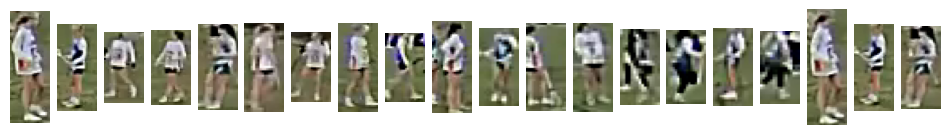

Team 1


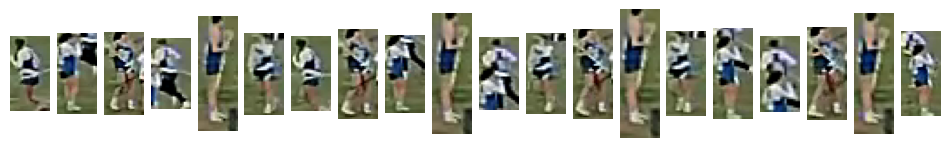

In [42]:
kmeans = KMeans(n_clusters=2, random_state=42)
embs_np = np.array(embs_3d)
team_identifier = kmeans.fit_predict(embs_np)

team_0 = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop, team in zip(crops_for_team_id, team_identifier) if team == 0]
team_1 = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop, team in zip(crops_for_team_id, team_identifier) if team == 1]

print("Team 0")
sv.plot_images_grid(team_0[:20], grid_size=(1, 20))

print("Team 1")
sv.plot_images_grid(team_1[:20], grid_size=(1, 20))

# Old Stuff #

In [ ]:
team_array = []
for crop in crops:
    crop = crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :]
    print (crop.shape)
    flat_crop = crop.reshape(-1, 3)
    flat_crop = flat_crop.astype(np.float32)
    flat_crop_norm = flat_crop / 255.0
    c_kmeans = KMeans(n_clusters=2, random_state=42)
    clusters = c_kmeans.fit_predict(flat_crop_norm)
    masked_crop = clusters.reshape(crop.shape[0], crop.shape[1])
    print(f"masked_crop shape: {masked_crop.shape}")
    corner_clusters = [masked_crop[0, 0], masked_crop[0, -1], masked_crop[-1, 0], masked_crop[-1, -1]]
    background_cluster = max(set(corner_clusters), key=corner_clusters.count)
    player_cluster = 1 - background_cluster  # Assuming two clusters, one is background
    jersey_color = c_kmeans.cluster_centers_[player_cluster]*255
    jersey_color = (jersey_color).astype(np.float32)
    jersey_color = jersey_color.reshape(1, -1)  # Reshape for prediction
    print (jersey_color)
    break
    team = kmeans.predict(jersey_color)
    team_array.append(team)
team_0_count = team_array.count(0)
team_1_count = team_array.count(1)
print(f"Team 0 count: {team_0_count}, Team 1 count: {team_1_count}")


In [ ]:
crop = crops[0]
crop = crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :]
flat_crop = crop.reshape(-1, 3)
flat_crop = flat_crop
flat_crop_norm = flat_crop 
flat_crop_norm = flat_crop_norm[~np.all(flat_crop_norm == 0, axis=1)]
#flat_crop_norm += 1e-7
print(f"flat_crop_norm shape: {flat_crop_norm.shape}")
c_kmeans = KMeans(n_clusters=2, random_state=42)
print(flat_crop_norm.min(), flat_crop_norm.max())
clusters = c_kmeans.fit_predict(flat_crop_norm)

plt.figure(figsize=(6, 6))
plt.imshow(crop)
plt.tight_layout()
plt.show()

In [ ]:
emb_for_id = emb_provider.get_emb_from_crops(crops_for_team_id)
team_identifier.train_team_identification(emb_for_id)

In [ ]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [ ]:
projections = REDUCER.fit_transform(emb_for_id)
clusters = CLUSTERING_MODEL.fit_predict(projections)
crops = [sv.cv2_to_pillow(crop) for crop in crops_for_team_id]

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(projections[:, 0], projections[:, 1], projections[:, 2], c=clusters, cmap='coolwarm', s=10)
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_zlabel('UMAP-3')
ax.set_title('3D UMAP Projection of Player Embeddings')
plt.show()

In [ ]:
teams = team_identifier.predict_team(emb_for_id)

mask = teams == 0
crops_team = [cv2.cvtColor(crop, cv2.COLOR_BGR2RGB) for crop, keep in zip(crops_for_team_id_bakup, mask) if keep]
crops_team = [crop for crop in crops_team if crop.shape[0] > 40 and crop.shape[1] > 18]  # Ensure crops are valid
sv.plot_images_grid(crops_team[:100], grid_size=(10, 10))

In [ ]:
import numpy as np

heights = [h for h, w in crop_shapes]
widths = [w for h, w in crop_shapes]

h_9th_decile = np.percentile(heights, 10)
w_9th_decile = np.percentile(widths, 10)

print(f"9th decile (90th percentile) of crop height: {h_9th_decile}")
print(f"9th decile (90th percentile) of crop width: {w_9th_decile}")

In [ ]:
crop_shapes = [(crop.shape[0], crop.shape[1]) for crop in crops_for_team_id_bakup]
print(crop_shapes[:100])  # Show the height and width of the first 10 crops

In [ ]:
frames_generator = sv.get_video_frames_generator(**generator_params)
previous_frame = None
affine_matrix = None

tracker_team_0 = AffineAwareByteTrack()
tracker_team_1 = AffineAwareByteTrack()

for frame in tqdm(frames_generator, desc="Frames read", total=frame_target):
    all_detections = model.generate_detections(frame)
    # all_detections = all_detections.with_nms(threshold=0.9, class_agnostic=True)

    # Affine matrix determines any camera move between consecutive frames (very important)
    if previous_frame is not None:
        affine_matrix = AffineAwareByteTrack.calculate_affine_transform(previous_frame, frame)
    if affine_matrix is None:
        affine_matrix = AffineAwareByteTrack.get_identity_affine_matrix()

    player_detections = all_detections[all_detections.class_id == _PLAYER_CLASS_ID]
    player_crops = [sv.crop_image(frame, xyxy=bbox) for bbox in player_detections.xyxy]
    player_embeddings = emb_provider.get_emb_from_crops(player_crops)
    player_teams = team_identifier.predict_team(player_embeddings)

    mask = player_teams == 0

    detections_team_0 = player_detections[mask]
    detections_team_1 = player_detections[~mask]

    detections_team_0.class_id = np.full_like(detections_team_0.class_id, 30, dtype=np.int8)
    detections_team_1.class_id = np.full_like(detections_team_1.class_id, 31, dtype=np.int8)

    detections_team_0 = tracker_team_0.update_with_transform(detections_team_0, affine_matrix, frame=frame.copy())
    detections_team_1 = tracker_team_1.update_with_transform(detections_team_1, affine_matrix, frame=frame.copy())

    previous_frame = frame.copy()
        
    multi_frame_detections.append((detections_team_0, detections_team_1))
    multi_ineligible_track_ids_team_0.append(tracker_team_0.get_tids_for_frame())
    multi_ineligible_track_ids_team_1.append(tracker_team_1.get_tids_for_frame())

In [ ]:
multi_frame_detections_bak = multi_frame_detections.copy()

In [ ]:
multi_frame_detections = multi_frame_detections_bak.copy()
frames_generator = sv.get_video_frames_generator(**generator_params)
with sv.VideoSink(target_path="results.mp4", video_info=video_info) as sink:
    for frame in tqdm(frames_generator, desc="Writing frames", total=frame_target):
       
        detections_team_0, detections_team_1 = multi_frame_detections.popleft()

        detections = sv.Detections(
            xyxy=np.concatenate([detections_team_0.xyxy, detections_team_1.xyxy]),
            confidence=np.concatenate([detections_team_0.confidence, detections_team_1.confidence]),
            class_id=np.concatenate([detections_team_0.class_id, detections_team_1.class_id]),
            tracker_id=np.concatenate([detections_team_0.tracker_id, detections_team_1.tracker_id])
        )

        annotated_frame = ellipse_annotator.annotate(
            scene=frame.copy(),
            detections=detections,
        )

        labels = [str(tid) for tid in detections.tracker_id]

        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=detections,
            labels=labels,
        )
        sink.write_frame(frame=annotated_frame)


In [ ]:
sv.plot_images_grid(processed_crops[:100], grid_size=(10, 10))